## Integrantes
- Nelson García  
- Diego Linares
- Joaquin Puente
- José Mérida
- Joaquín Campos

# Análisis exploratorio

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Carga de Datos y Revisión General

In [2]:
# estaremos definiendo ambos csvs para poder tener acceso a ambos pero usaremos el train y luego sobre el test replicaremos una vez se considere importante
dftest = pd.read_csv("../data/test.csv")

# Definir NA como nuestros NaN
dftrain = pd.read_csv("../data/train.csv", na_values=["NA"])

# incluimos en el analissi exploratorio lo basico para poder tenerlo a la mano
dftrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# datos estadísticos básicos 
dftrain.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
# tipos
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Revisamos posibles variables redundantes entre sí mismas
print(dftrain.nunique())

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64


## Eliminación de Filas Duplicadas

In [6]:
before = dftrain.shape[0]

# Eliminar duplicados
dftrain = dftrain.drop_duplicates()
after = dftrain.shape[0]
print(f"Filas eliminadas: {before - after}")

Filas eliminadas: 0


No existen filas duplicadas.

# Exploración de Variables Categóricas

In [7]:
# cuántas categorías únicas hay por columna?
print(dftrain.select_dtypes(include=['object']).nunique())  

print("Distribucion de categorias por columna: ") 
# Distribución de categorías por columna
for col in dftrain.select_dtypes(include=['object']).columns:
    print(dftrain[col].value_counts())  

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        3
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64
Distribucion de categorias por columna: 
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      

Gracias a este output podemos "observar" de forma rápida, que algunas de las variables como utilities, un poco LandSlope, Condition2 y tal vez otras variables pueden ser eliminadas, pero necesitamos poder justificar, de esta forma igual ya nos podemos hacer una idea de como hay algunas variables que tienen poca relevancia. 

# Exploracion de Variables Numéricas

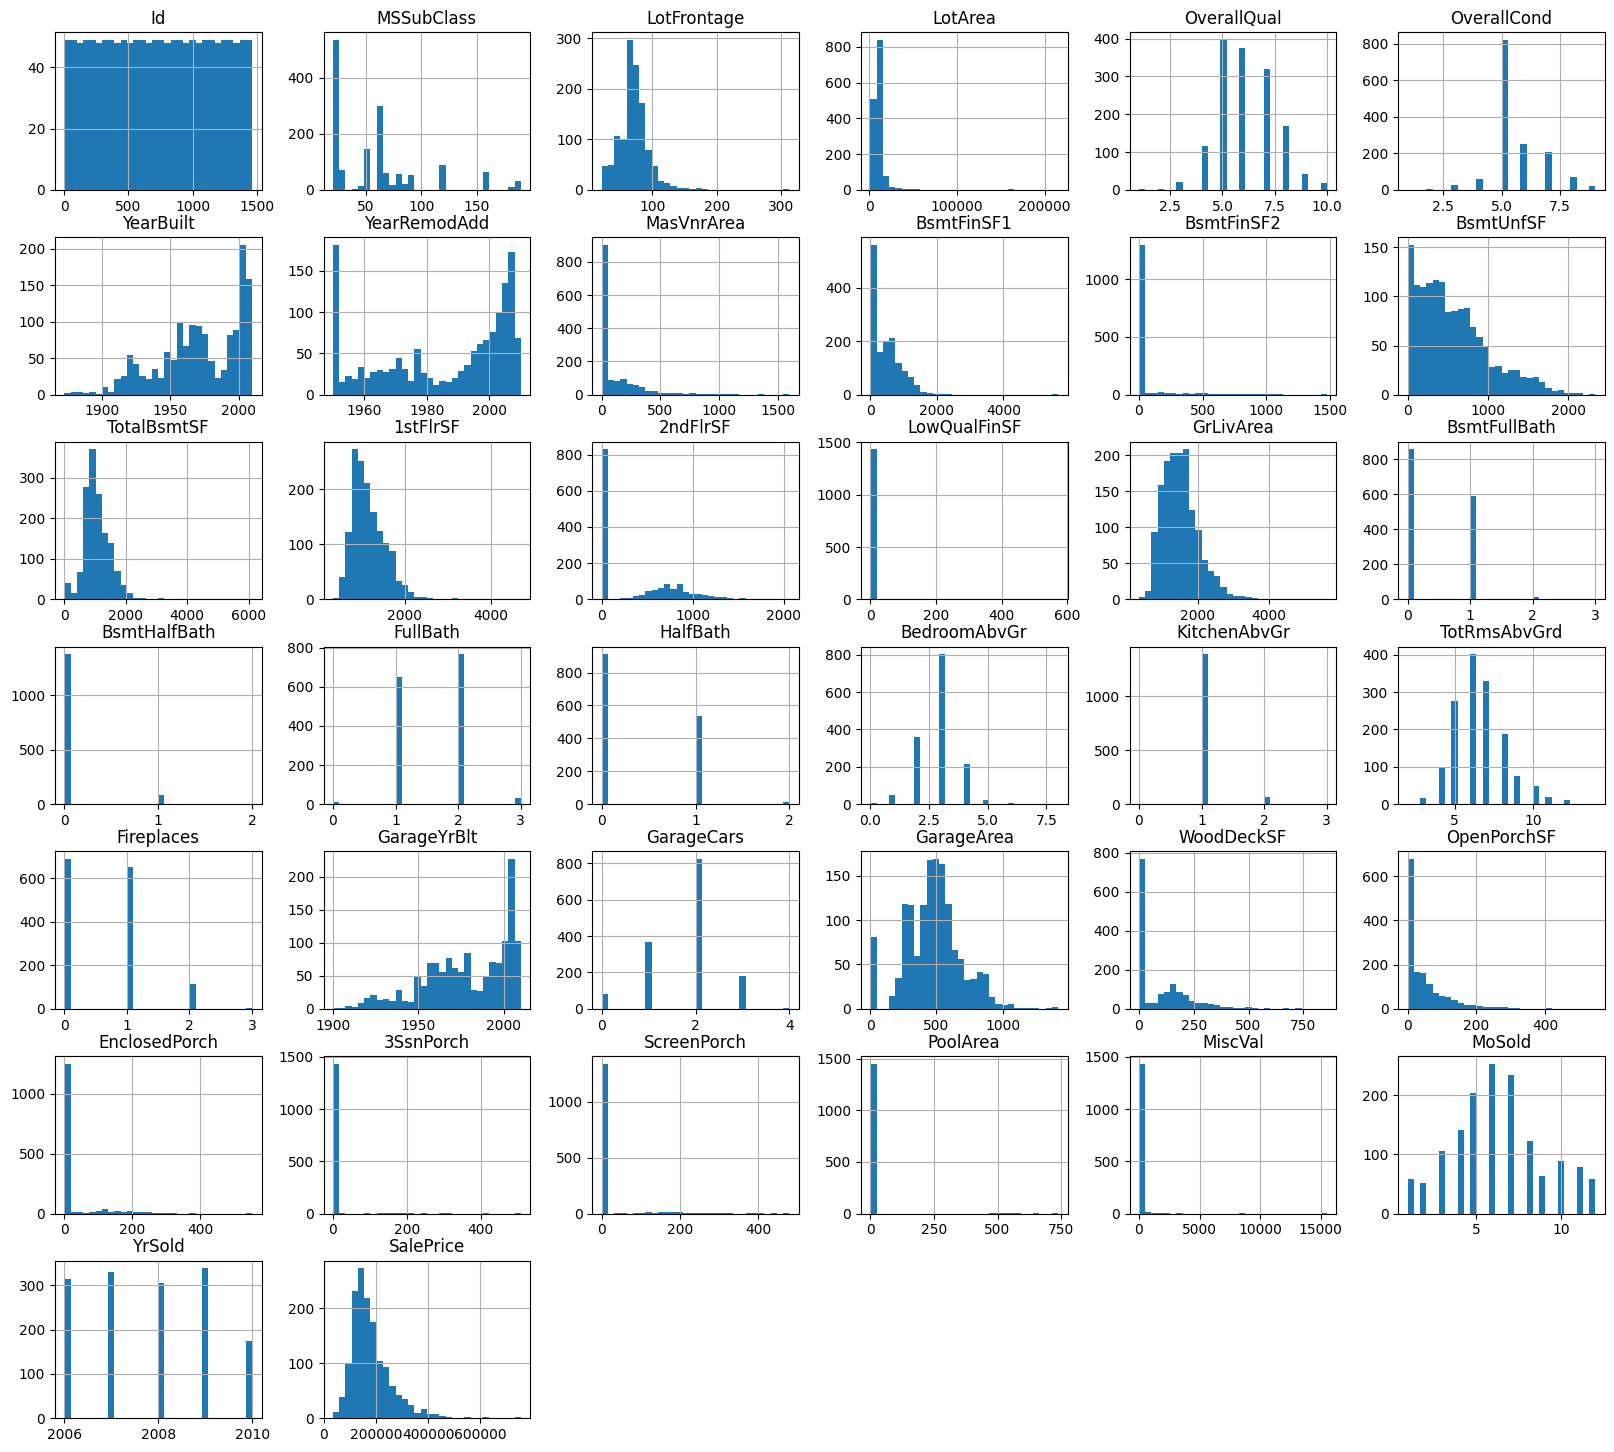

In [8]:
# Visualizacion y observacion variables numericas
dftrain.hist(figsize=(20, 18), bins=30)
plt.show()

Gracias a esto podemos imaginar que hay bastantes variables con nulas, o como wooddeckSF en donde parece que la varianza es baja podemos identificar tambien que ademas hay bastantes varaibles que pueden sernos de gran utilidad en la busqueda de salesPrice pero sobre todo variables que tienden a una moda y como estas distribuciones que podriamos usar. 

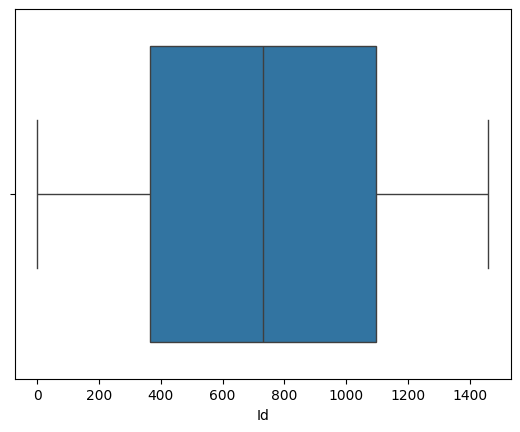

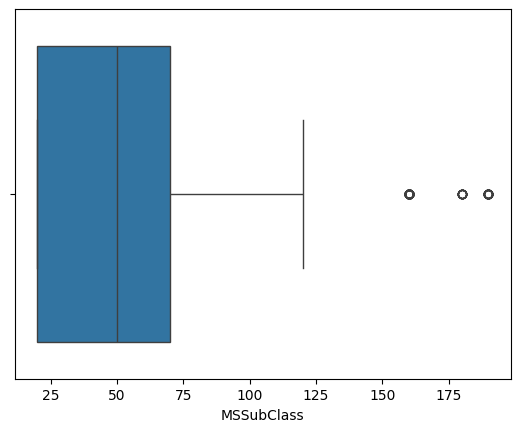

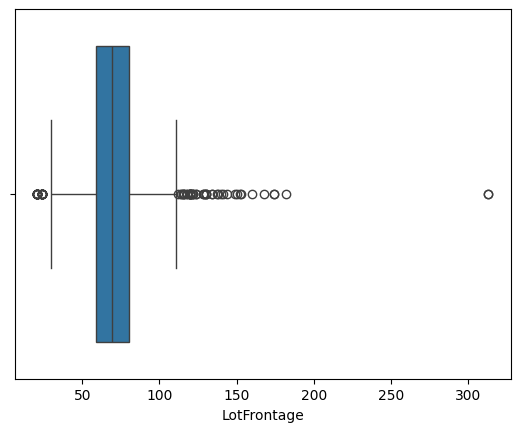

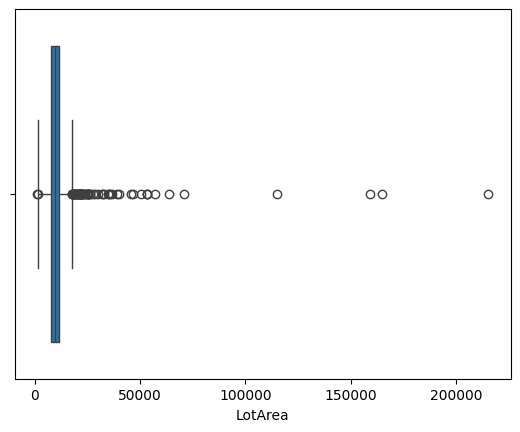

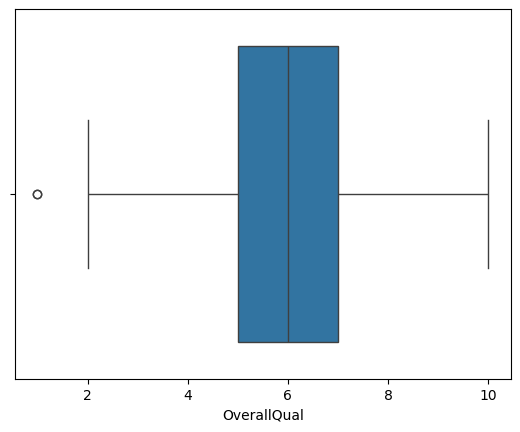

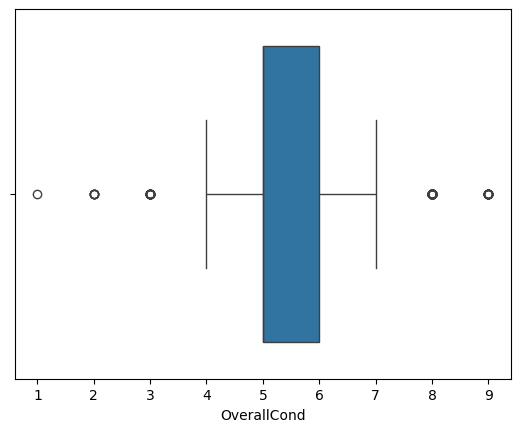

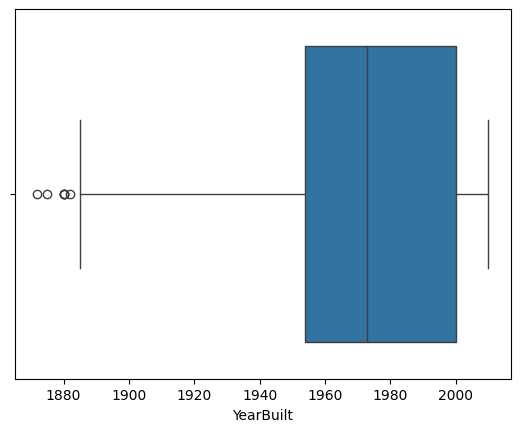

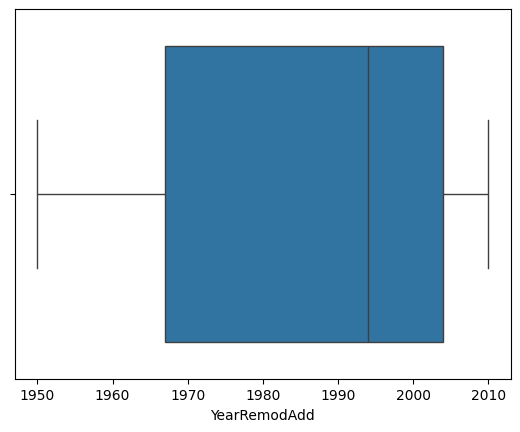

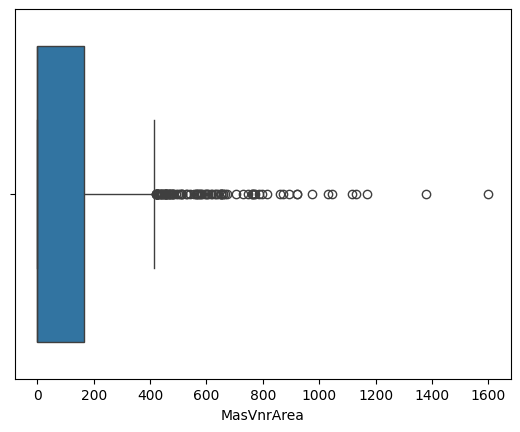

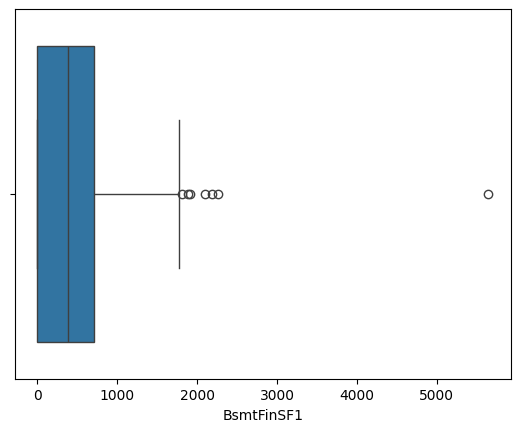

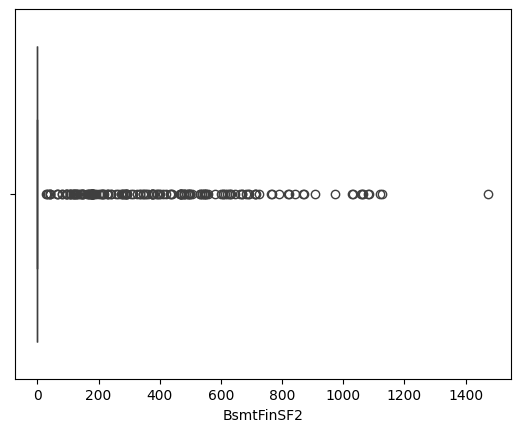

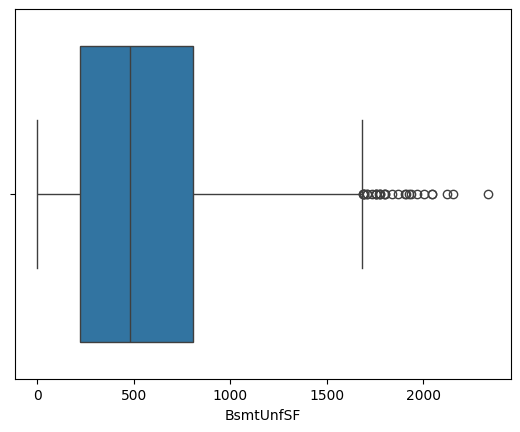

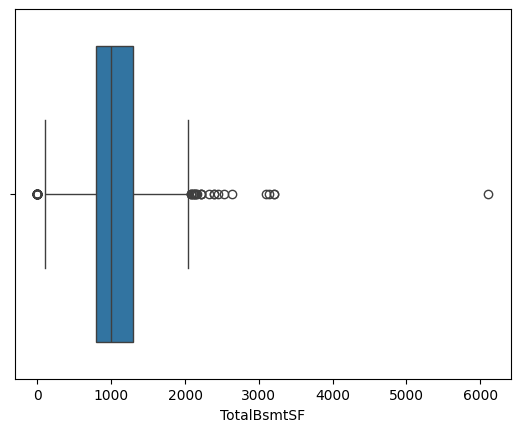

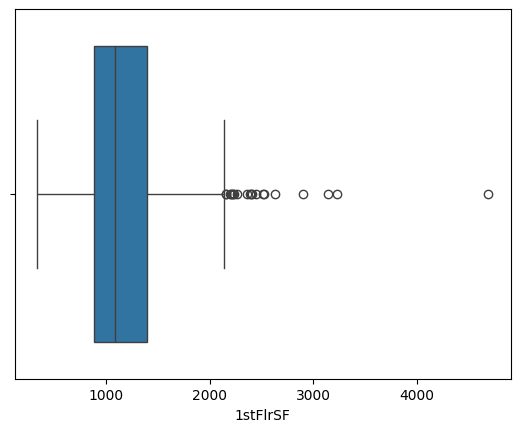

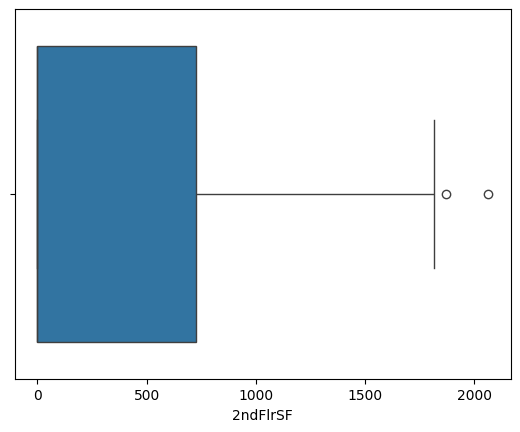

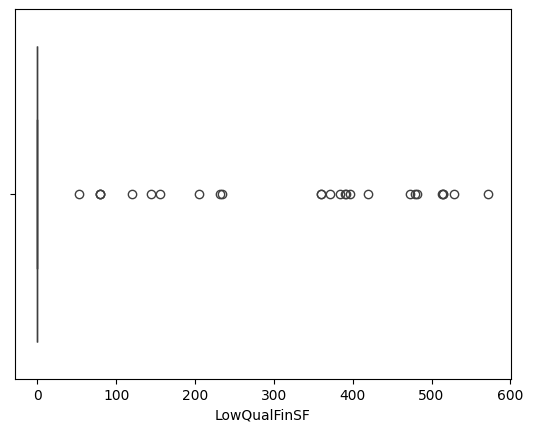

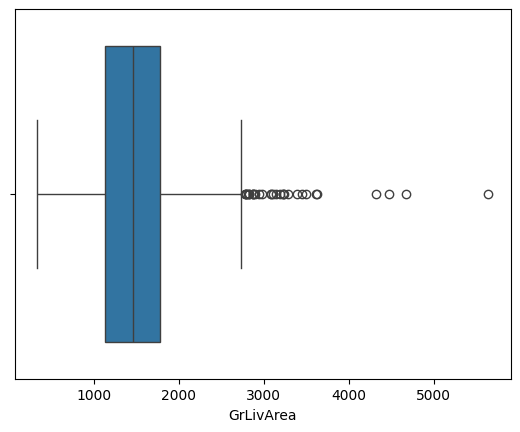

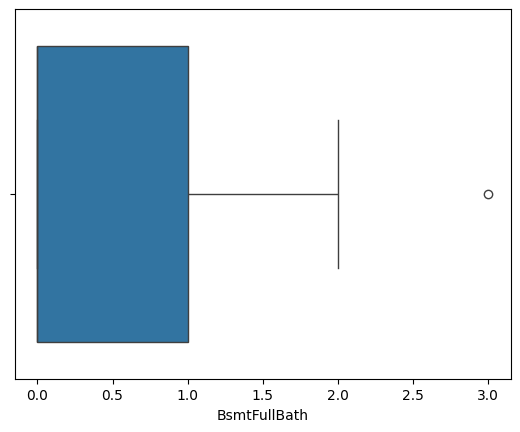

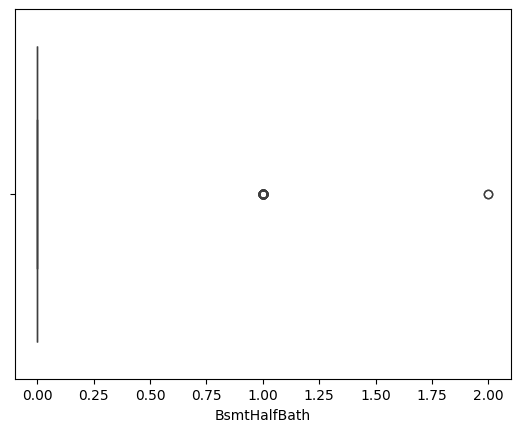

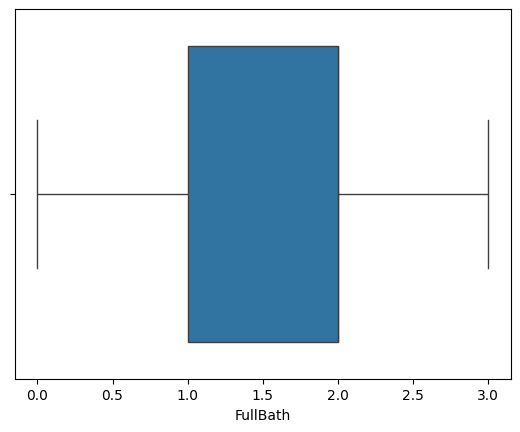

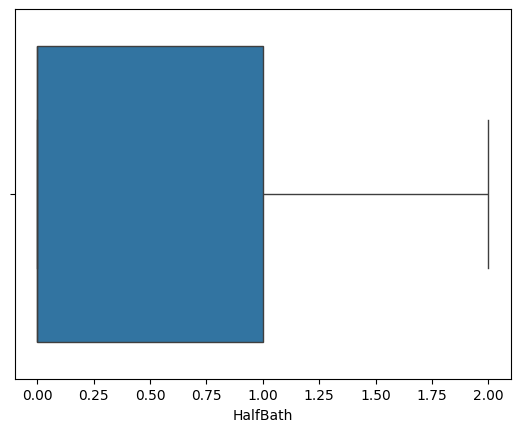

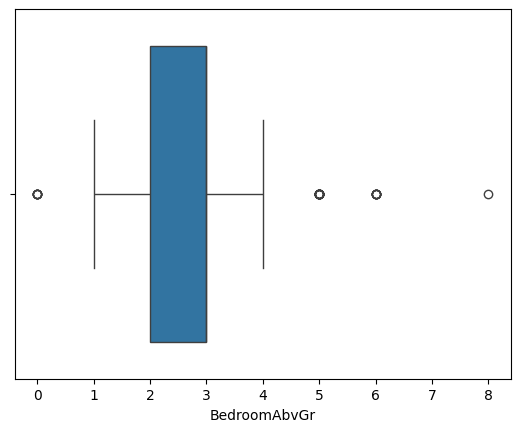

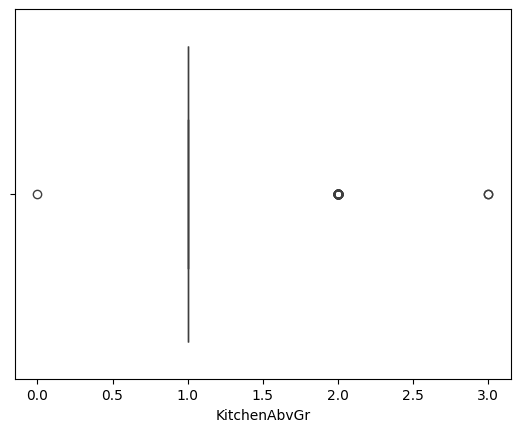

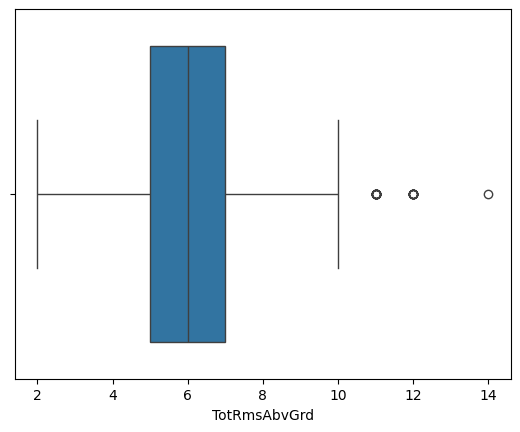

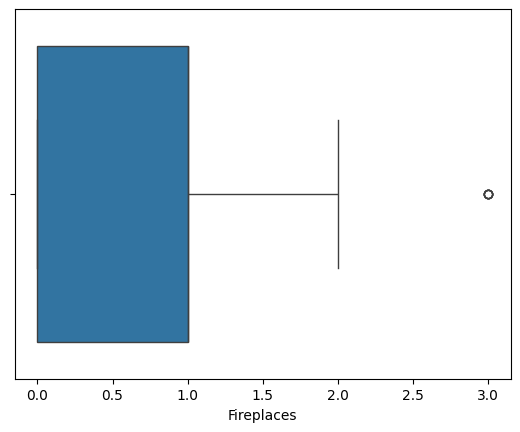

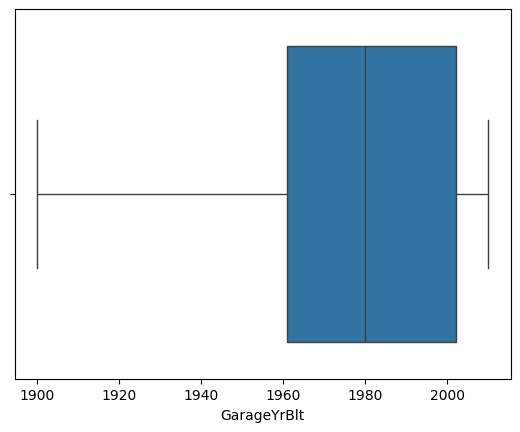

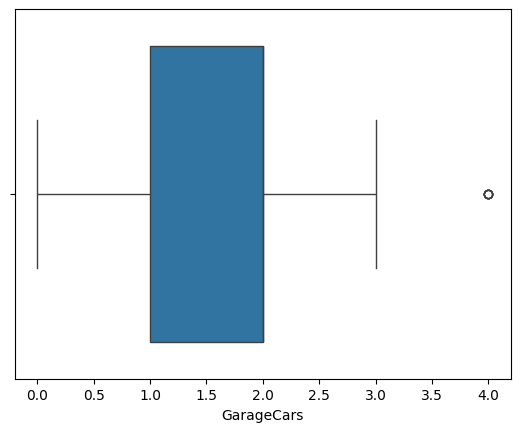

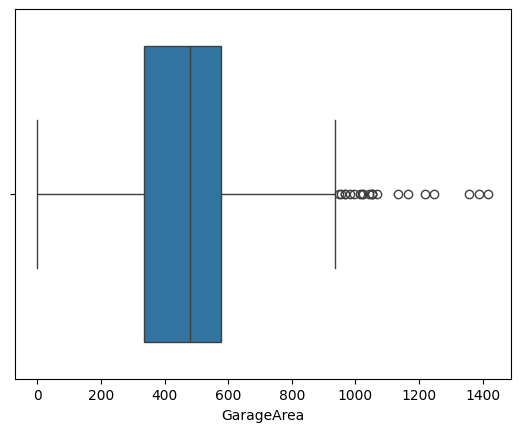

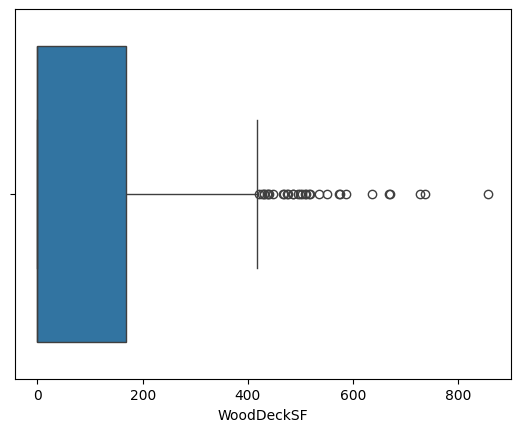

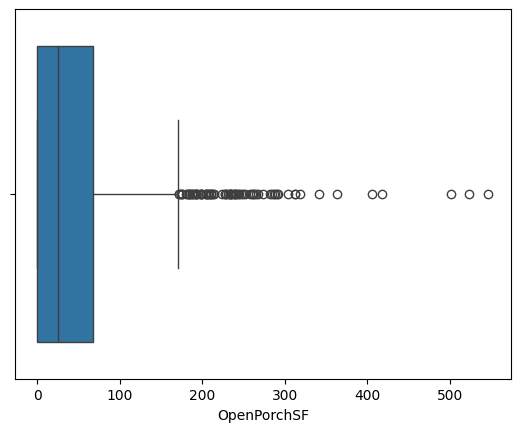

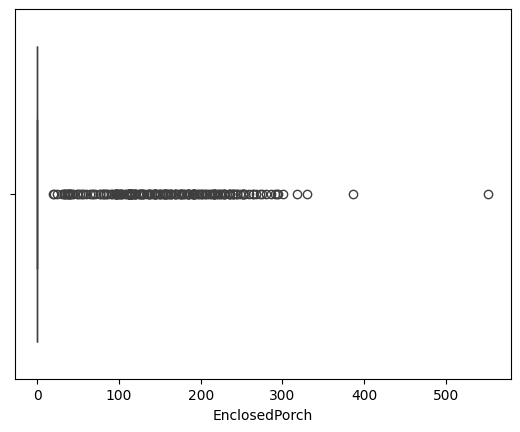

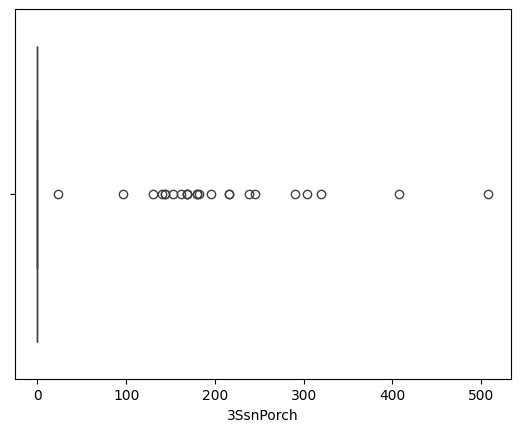

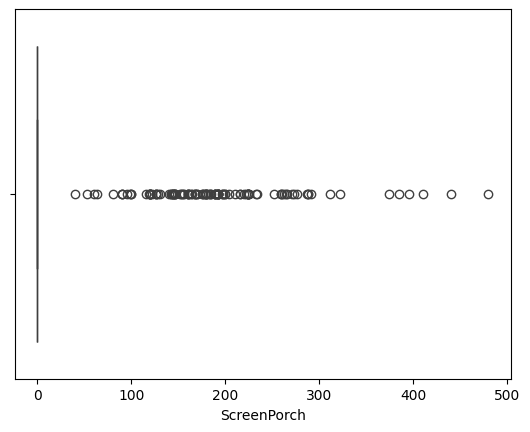

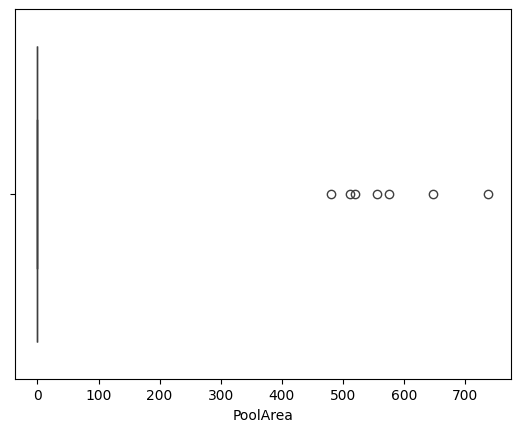

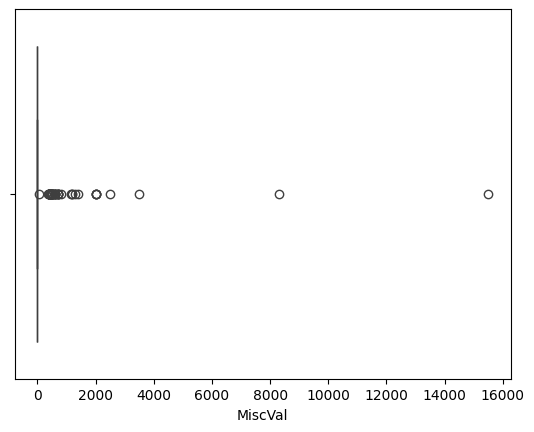

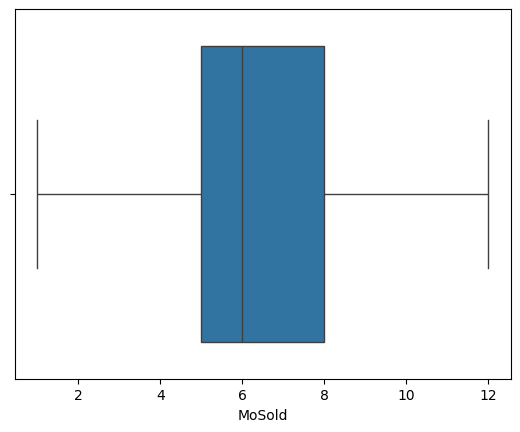

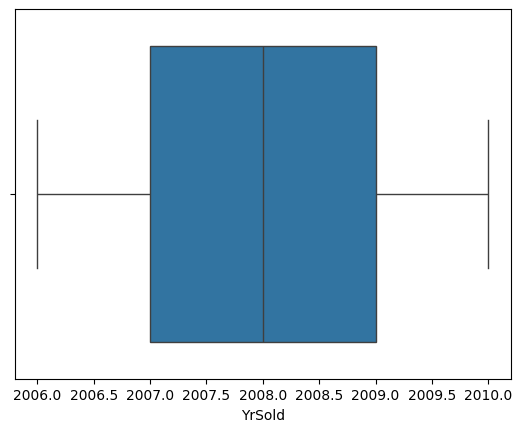

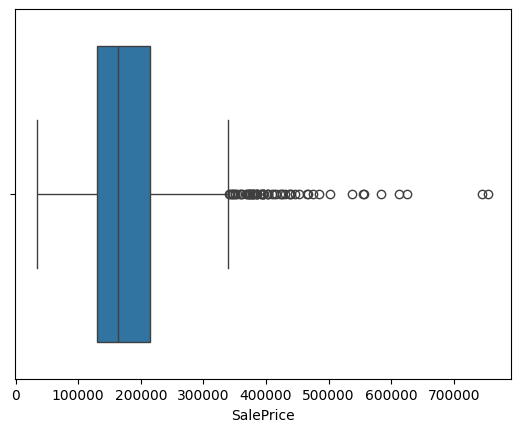

In [9]:
# Boxplots para detectar outliers
for col in dftrain.select_dtypes(include=['number']).columns:
    sns.boxplot(x=dftrain[col])
    plt.show()

En base a esto podemos definir que algunas variables tienen valores atipicos, no obstante deberiamos de evaluar primero las variables para ver si son necesarias

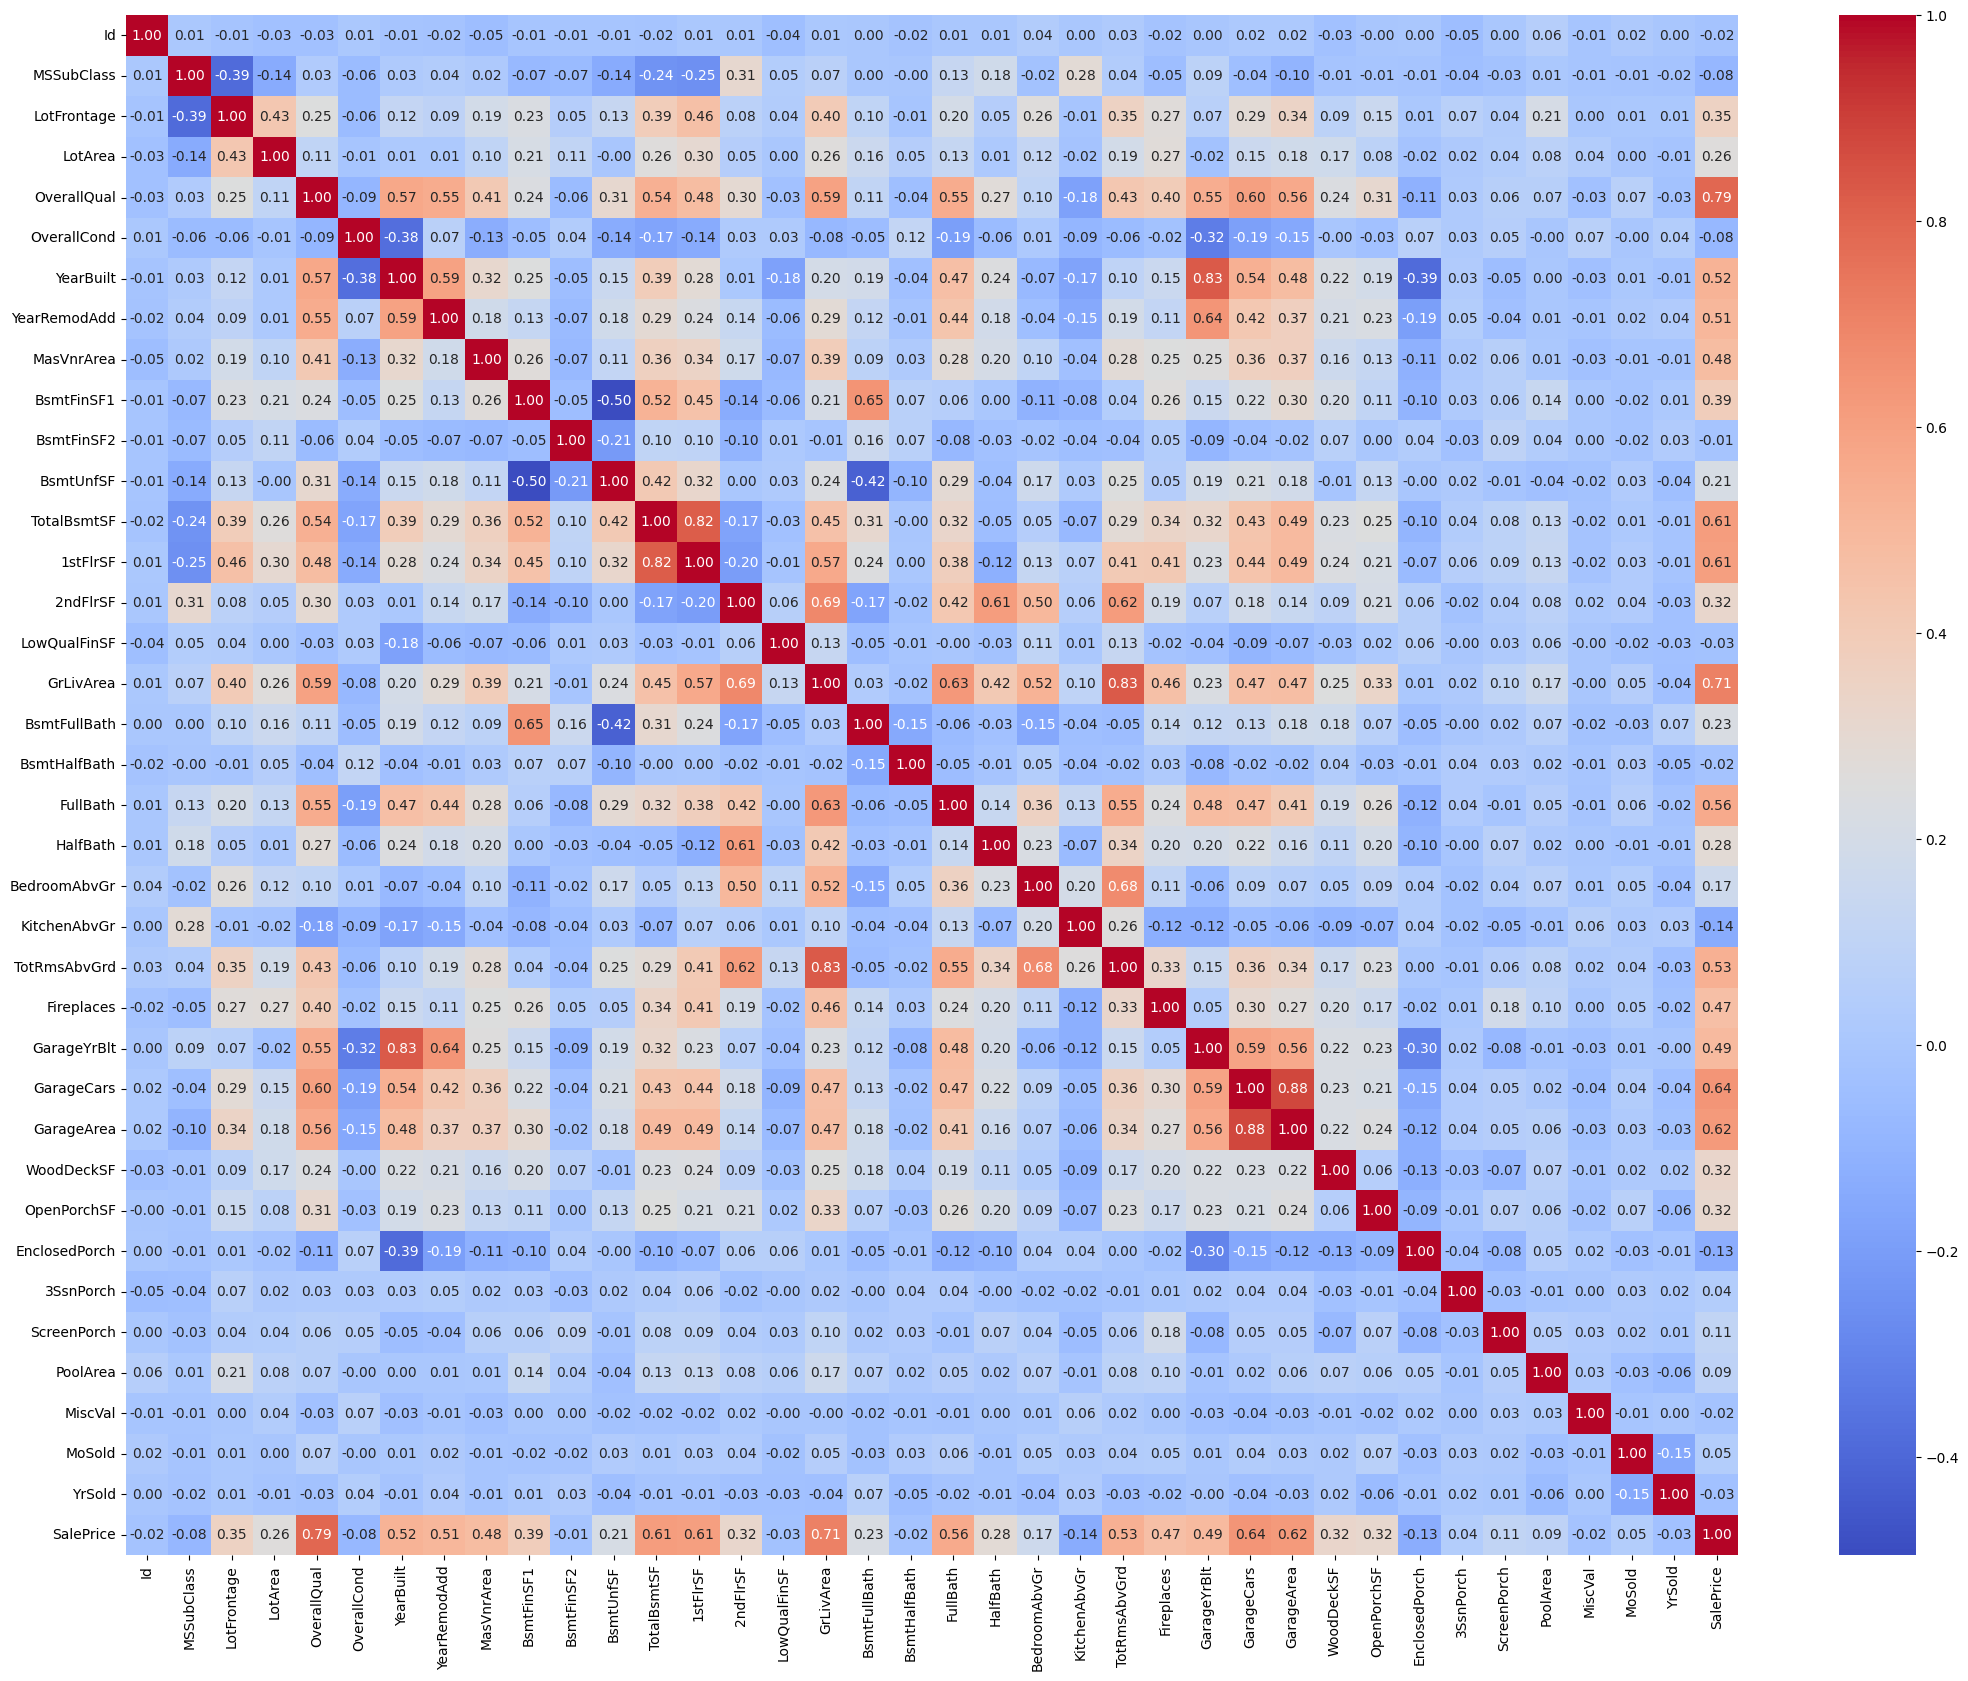

In [10]:
# correlación evaluacion de posibles variables eliminables
plt.figure(figsize=(26, 20))
df_numeric = dftrain.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### """importante""" 
#### que al no ser expertos gracias a la correlacion podemos definir que el precio esta realacionado altamente con: OverallQual y GrLivArea de manera que podemos usar esto para poder ayudarnos

Segun esto podemos ver que la correlacion entre las variables númericas pero aún asi no podemos descartar ninguna variable porque la correlacion no tienen numeros altos para poder eliminarla con justificacion. 

### Evaluaciones entre variables 2darias para ver redundancia con la 1


In [11]:
# condition
condition_diff_count = (dftrain["Condition1"] != dftrain["Condition2"]).sum()
print(f"Number of rows with different Condition1 and Condition2: {condition_diff_count}")
# exterior
exterior_diff_count = (dftrain["Exterior1st"] != dftrain["Exterior2nd"]).sum()
print(f"Number of rows with different Exterior1st and Exterior2nd: {exterior_diff_count}")
# BsmtFinSF2
bsmt_diff_count = (dftrain["BsmtFinSF1"] != dftrain["BsmtFinSF2"]).sum()
print(f"Number of rows with different BsmtFinSF1 and BsmtFinSF2: {bsmt_diff_count}")

Number of rows with different Condition1 and Condition2: 195
Number of rows with different Exterior1st and Exterior2nd: 215
Number of rows with different BsmtFinSF1 and BsmtFinSF2: 991


En conclusion podemos definir que las variables 2darias no las podemos eliminar del todo porque numeros como 195 son pesados o voluminosos para posibles calculos en el futuro con SalesPrice


### Variables con valores nulos


In [12]:
# Verificar cuántos valores nulos hay en cada columna
missing_values = dftrain.isnull().sum() / len(dftrain) * 100
print(missing_values.sort_values(ascending=False))

PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
MasVnrType       59.726027
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64


Con este output podemos eliminar 4 variables irrelevantes (PoolQC, MiscFeature, Alley, Fence) porque tienen NaN en 80% o más (recordemos que NA se establecio el NA como el na_value al leer en el csv)

## ¿El Id valdrá la pena?
Al ser el Id solo un identificador unico de las casas no es relevante para el valor que estamos buscando predecir

In [13]:
dftrain_original = dftrain.copy()  # Guarda una copia por si acaso
dftrain = dftrain.drop(["Id", "MiscFeature", "PoolQC", "Alley", "Fence"], axis=1)

Hacemos la eliminacion de las variables que hemos justificado para las evaluaciones


In [14]:
#Para verificar que se han eliminado.
print(dftrain.columns.tolist())

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'Y

Despues de eliminar esas columnas, podriamos volver a contar valores nulos por columna. 

In [15]:
# Contar valores nulos por columna
missing_values = dftrain.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageQual       81
GarageFinish     81
GarageType       81
GarageCond       81
GarageYrBlt      81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtQual         37
BsmtCond         37
MasVnrArea        8
Electrical        1
dtype: int64

Para variables nulos en numericas se reemplazaran con la mediana.

In [16]:
# Reemplazo en numéricas
num_cols = dftrain.select_dtypes(include=["number"]).columns
dftrain[num_cols] = dftrain[num_cols].fillna(dftrain[num_cols].median())
print(dftrain.isnull().sum())  # verificacion qque todos los nan fuesen eliminados.

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64


# Analisis de variables categoricas.
Empezaremos viendo la cantidad o como que tantas variables distintas existen en estas columnas: 

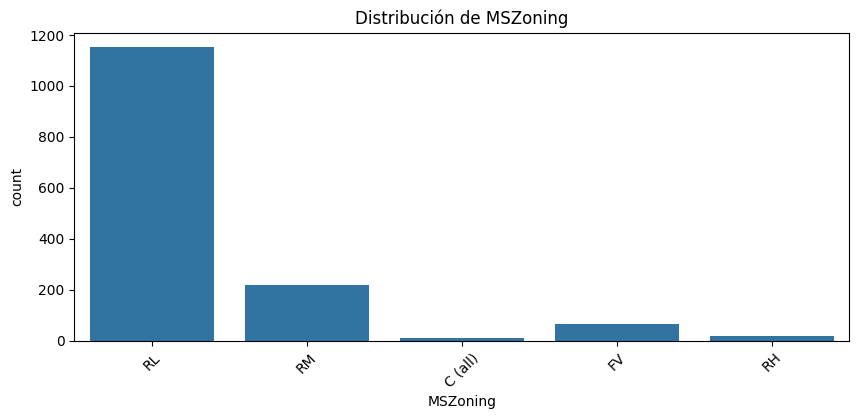

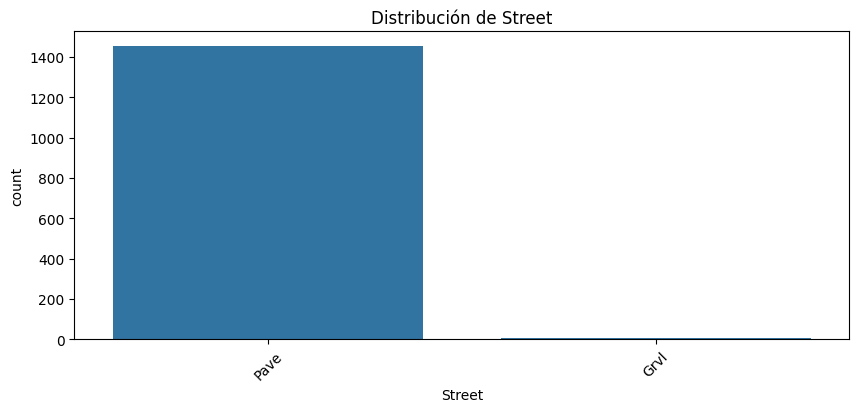

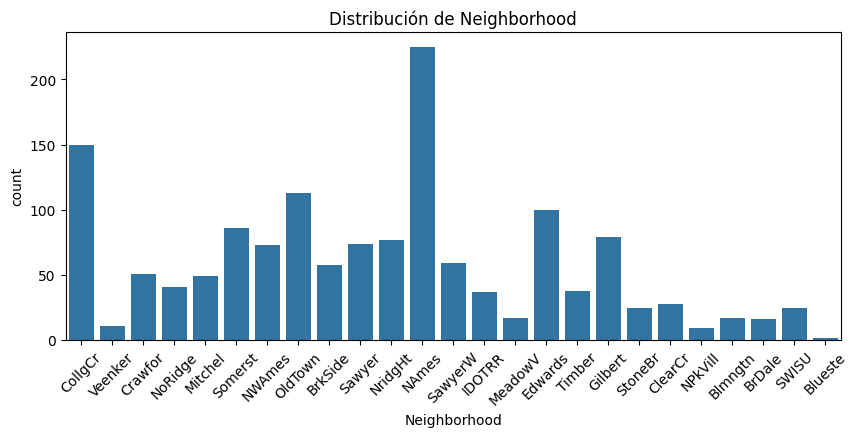

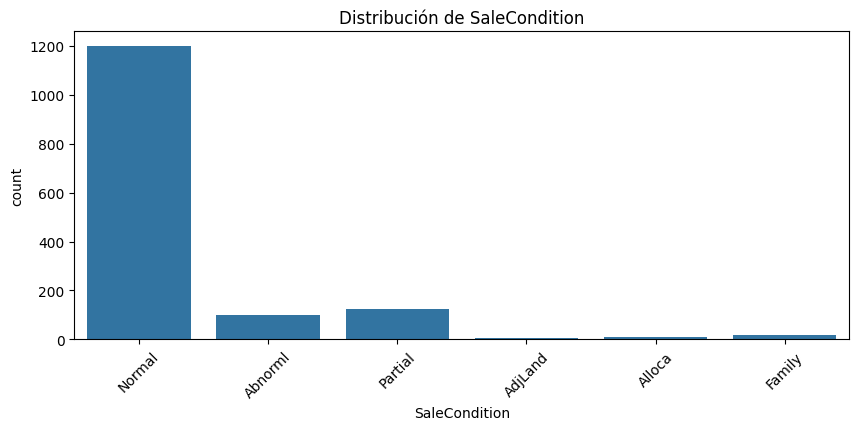

In [17]:
# Conteo de categorías en variables clave
cat_features = ["MSZoning", "Street", "Neighborhood", "SaleCondition"]

for col in cat_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=dftrain, x=col)
    plt.xticks(rotation=45)
    plt.title(f"Distribución de {col}")
    plt.show()


### ¿Qué vecindarios tienden a ser mas "caros"?

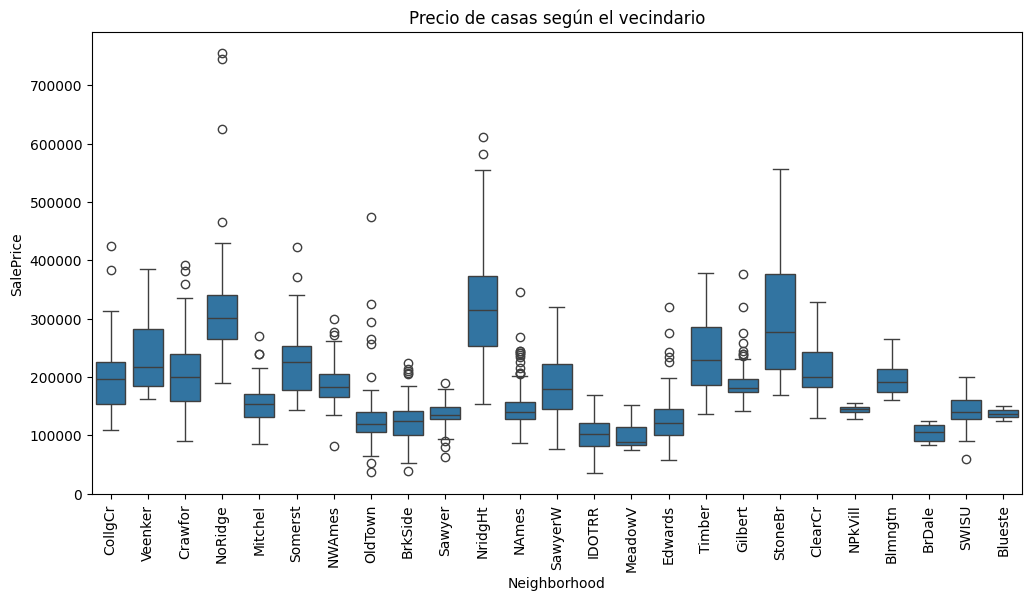

In [18]:
# Boxplot de Neighborhood vs SalePrice
plt.figure(figsize=(12, 6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=dftrain)
plt.xticks(rotation=90)
plt.title("Precio de casas según el vecindario")
plt.show()


Usando el test podemos evaluar que hay vecindarios que son mas caros igualmente este no lo podemos usar porque en teoria no tenemos SalePrice

### ¿Qué "Vecindario" se venden las propiedades mas grandes?

In [19]:
# Agrupar por vecindario y calcular el promedio del tamaño del terreno y área habitable
zonas_mas_grandes = dftrain.groupby("Neighborhood")[["LotArea", "GrLivArea"]].mean()

# Ordenar de mayor a menor por tamaño del terreno
zonas_mas_grandes = zonas_mas_grandes.sort_values(by="LotArea", ascending=False)
print(zonas_mas_grandes.head(10))

                   LotArea    GrLivArea
Neighborhood                           
ClearCr       30875.750000  1788.107143
Timber        23664.236842  1749.368421
Veenker       15606.000000  1539.636364
NoRidge       14218.902439  2508.853659
NWAmes        11833.630137  1727.780822
Crawfor       11809.686275  1791.607843
Mitchel       11624.285714  1294.204082
Gilbert       11379.151899  1641.316456
NridgHt       10887.948052  1915.948052
StoneBr       10671.920000  1879.080000


Con esta pregunta podremos rescatar al afinar que GrLivArea tiene correlacion alta con PriceSales, cuales tienden a ser los vecindarios mas "caros"